In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf

2024-06-18 13:28:09.012743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 13:28:09.457668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-18 13:28:09.457734: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-18 13:28:09.523255: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 13:28:11.207749: W tensorflow/stream_executor/platform/de

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Pre

In [3]:
data_folder = "data"
filename = "train.csv"
df = pd.read_csv(os.path.join("..", data_folder, filename), parse_dates=True, index_col="date")

In [4]:
df_subset = df[["warehouse", "orders"]]
df_subset.head()

,warehouse,orders
date,,
2020-12-05,Prague_1,6895.0
2020-12-06,Prague_1,6584.0
2020-12-07,Prague_1,7030.0
2020-12-08,Prague_1,6550.0
2020-12-09,Prague_1,6910.0


In [5]:
Prague_1_df = df_subset[df_subset["warehouse"] == "Prague_1"].drop(columns=["warehouse"])
Prague_1_df.shape

(1193, 1)

In [6]:
# Convert to numpy arrays

time_steps = np.array(range(len(Prague_1_df)))
series = Prague_1_df["orders"].values

In [7]:
series.shape

(1193,)

## Split the Dataset

In [8]:
# Take the last year as validation set
split_time = len(Prague_1_df) - 365

# Get the train set
time_train = time_steps[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_steps[split_time:]
x_valid = series[split_time:]

In [9]:
x_valid.shape

(365,)

## Prepare Features and Labels

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [11]:
# Parameters
window_size = 365
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-18 13:28:14.131349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-18 13:28:14.131453: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-18 13:28:14.131556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FP4OP26): /proc/driver/nvidia/version does not exist
2024-06-18 13:28:14.132777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Building the model

In [12]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 365, 64)           256       
                                                                 
 lstm (LSTM)                 (None, 365, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

In [13]:
# Set the learning rate
learning_rate = 0.001

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [14]:
# Train the model
history = model.fit(train_set, epochs=15)

Epoch 1/15
15/15 [==============================] - 13s 587ms/step - loss: 8635.3242 - mean_absolute_percentage_error: 99.9968
Epoch 2/15
15/15 [==============================] - 8s 526ms/step - loss: 8634.0674 - mean_absolute_percentage_error: 99.9821
Epoch 3/15
15/15 [==============================] - 8s 514ms/step - loss: 8630.1992 - mean_absolute_percentage_error: 99.9367
Epoch 4/15
15/15 [==============================] - 8s 497ms/step - loss: 8602.8545 - mean_absolute_percentage_error: 99.6168
Epoch 5/15
15/15 [==============================] - 8s 490ms/step - loss: 6766.2993 - mean_absolute_percentage_error: 78.4248
Epoch 6/15
15/15 [==============================] - 8s 495ms/step - loss: 2260.8574 - mean_absolute_percentage_error: 26.2814
Epoch 7/15
15/15 [==============================] - 8s 507ms/step - loss: 1254.1787 - mean_absolute_percentage_error: 14.6815
Epoch 8/15
15/15 [==============================] - 8s 534ms/step - loss: 1049.6569 - mean_absolute_percentage_error:

## Model Prediction

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

12/12 [==============================] - 3s 171ms/step


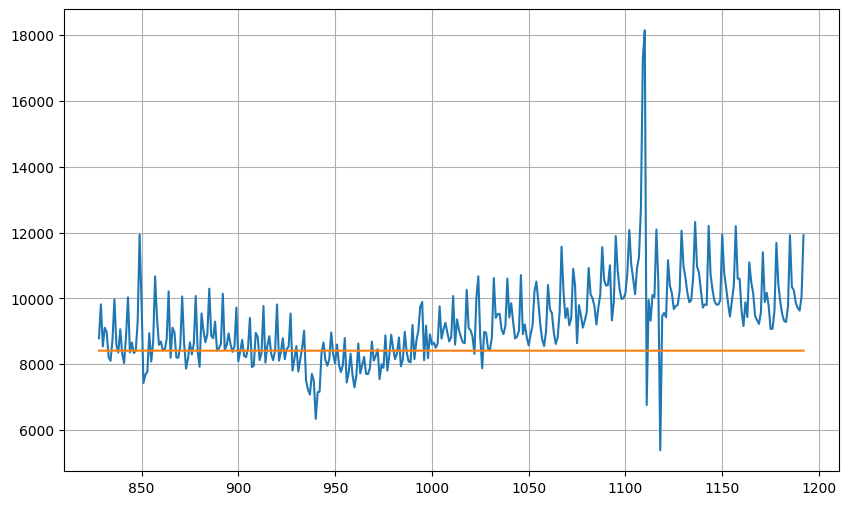

In [16]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
print(x_valid.shape)
print(results.shape)

# Compute the MAPE
print(mean_absolute_percentage_error(x_valid, results) * 100)

(365,)
(365,)
10.727854632961703
